In [1]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import collections
import pickle
import gc

In [2]:
df_nostr = pd.read_csv('yt_allcountry_trend5days_nostr.csv', index_col=None)

In [3]:
X = df_nostr.drop(['trend_over_5_days'],axis=1)
y = df_nostr['trend_over_5_days']

In [4]:
X

,views,likes,dislikes,comment_count
0,17158579,787425,43420,125882
1,1014651,127794,1688,13030
2,3191434,146035,5339,8181
3,2095828,132239,1989,17518
4,33523622,1634130,21082,85067
...,...,...,...,...
178694,279728,19691,135,579
178695,1549110,21905,1516,1318
178696,2183462,79677,2034,3464
178697,607422,26166,895,3517


In [5]:
y

0         1
1         0
2         1
3         1
4         1
         ..
178694    0
178695    0
178696    0
178697    0
178698    0
Name: trend_over_5_days, Length: 178699, dtype: int64

### PCA on 4 components?

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca.fit(X)

PCA(n_components=4)

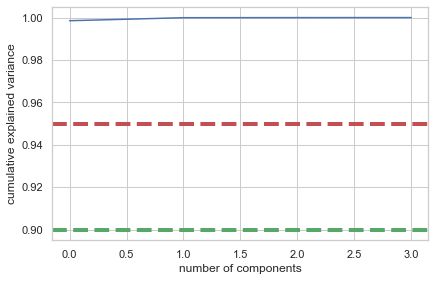

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.998518,0.998518
1,0.999936,0.001419
2,0.999983,0.000047
3,1.000000,0.000017


In [7]:
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
# plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
plt.axhline(linewidth=4, color='r', linestyle = '--', y=0.95, xmin=0, xmax=1)
plt.axhline(linewidth=4, color='g', linestyle = '--', y=0.90, xmin=0, xmax=1)

display(plt.show())

evr = pca.explained_variance_ratio_
cvr = np.cumsum(pca.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [143]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [144]:
X_train

,views,likes,dislikes,comment_count
113617,126706,6061,64,4418
65534,14658,122,21,9
126111,9568,141,5,10
8740,32051,3006,40,665
57496,11716,2018,6,130
...,...,...,...,...
119879,7996,38,8,14
103694,78227,1082,45,356
131932,98261,501,60,23
146867,16583,177,14,33


In [145]:
X_test

,views,likes,dislikes,comment_count
117989,2592,125,2,3
101258,30968,1900,32,219
44861,39277,720,72,312
5811,77884,814,119,617
63847,136815,362,201,375
...,...,...,...,...
131037,8259,569,4,86
112353,287445,1475,133,522
75019,78071,1191,42,33
93855,88752,1043,146,118


### Classifier 1: Naive Bayes - Gaussian Naive Bayes

In [10]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, CategoricalNB

In [11]:
%%time
GNB = GaussianNB()
GNB.fit(X_train, y_train)

Wall time: 29 ms


GaussianNB()

In [12]:
%%time
GNB.score(X_test, y_test)

Wall time: 12 ms


0.9582540570789032

In [13]:
%%time
from sklearn.model_selection import cross_val_score

GNB_cvs = cross_val_score(GNB, X, y, 
                          cv=10, 
                          n_jobs=-1,)

print(f"GaussianNB 10-CV score: {GNB_cvs}")
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(GNB_cvs)}")

GaussianNB 10-CV score: [0.92126469 0.95422496 0.96552882 0.97437045 0.9616676  0.96614438
 0.96205932 0.96149972 0.95148293 0.95327103]
GaussianNB 10-fold Cross Val Avg: 0.9571513893174485
Wall time: 2.98 s


In [14]:
print(len(GNB.predict_proba(X_test)))
GNB_probs = GNB.predict_proba(X_test)
GNB_probs
# print(min(GNB_probs[0])

44675


array([[9.99960618e-01, 3.93821209e-05],
       [9.99962228e-01, 3.77718098e-05],
       [9.99962180e-01, 3.78195999e-05],
       ...,
       [9.99962636e-01, 3.73642593e-05],
       [9.99962958e-01, 3.70417950e-05],
       [9.99960876e-01, 3.91239063e-05]])

In [15]:
GNB_probs[:,0]

array([0.99996062, 0.99996223, 0.99996218, ..., 0.99996264, 0.99996296,
       0.99996088])

In [16]:
GNB_probs[:,1]

array([3.93821209e-05, 3.77718098e-05, 3.78195999e-05, ...,
       3.73642593e-05, 3.70417950e-05, 3.91239063e-05])

In [17]:
print(f"min of left col = {min(GNB_probs[:,0])}, max of right col = {max(GNB_probs[:,1])}")
print(f"max of left col = {max(GNB_probs[:,0])}, min of right col = {min(GNB_probs[:,1])}")

min of left col = 0.0, max of right col = 1.0
max of left col = 0.999964201117343, min of right col = 3.579888265721081e-05


In [18]:
len(GNB_probs[:,0])

44675

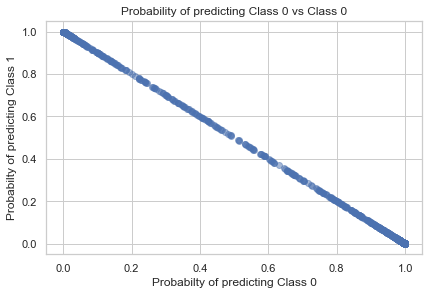

In [19]:
fig, ax = plt.subplots()
plt.scatter(GNB_probs[:,0], GNB_probs[:,1], alpha=0.5)

plt.title('Probability of predicting Class 0 vs Class 1')
ax.set_xlabel('Probabilty of predicting Class 0')
ax.set_ylabel('Probabilty of predicting Class 1')

plt.show()

In [34]:
for i, val in enumerate(GNB_probs[:,0]):
    if i < 10:
        print(i, val)

0 0.9999606178791351
1 0.9999622281901729
2 0.9999621804001358
3 0.9999630191510568
4 0.9999632510195968
5 0.9999618186963986
6 0.9999630799179788
7 0.9999621963438134
8 0.9999541332421376
9 0.9999635591594567


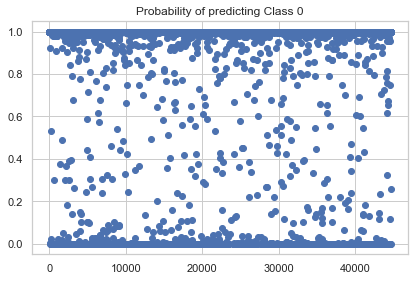

In [36]:
xrange = [i for i in range(len(GNB_probs[:,0]))]
plt.scatter(xrange, GNB_probs[:,0])
plt.title('Probability of predicting Class 0')

plt.show()

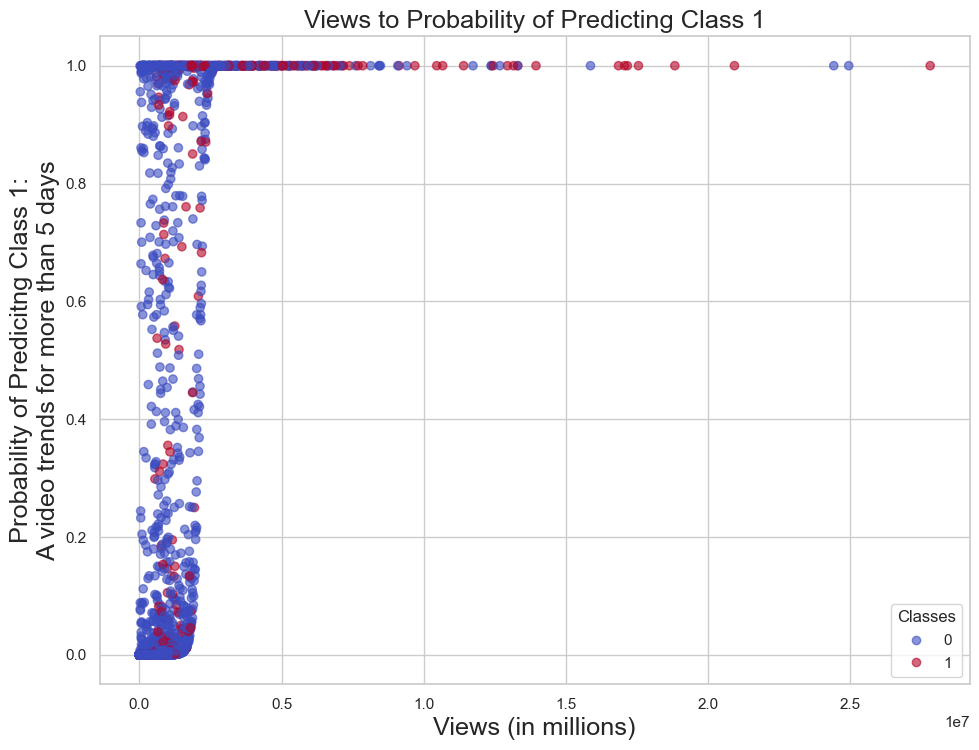

In [128]:
plt.figure(figsize=(10, 8), dpi=100)

scatter = plt.scatter(X_test['views'], GNB_probs[:,1], 
                        c=y_test, 
                        cmap='coolwarm',
                        alpha=0.6)
plt.title('Views to Probability of Predicting Class 1', fontsize='small')
plt.xlabel('Views (in millions)', fontsize='small')
plt.ylabel('Probability of Predicitng Class 1:\nA video trends for more than 5 days', fontsize='small')
plt.rcParams.update({'font.size': 22})


plt.legend(*scatter.legend_elements(), loc='lower right', title='Classes')
# ax.legend()

plt.show()

In [ ]:
plt.figure(figsize=(10, 8), dpi=100)

scatter = plt.scatter(X_test['views'], GNB_probs[:,0], 
                        c=y_test, 
                        cmap='coolwarm',
                        alpha=0.6)
plt.title('Views to Probability of Predicting Class 0', fontsize='small')
plt.xlabel('Views (in millions)', fontsize='small')
plt.ylabel('Probability of Predicitng Class 0:\n A video trends for 5 or less days', fontsize='small')
plt.rcParams.update({'font.size': 22})


plt.legend(*scatter.legend_elements(), loc='upper right', title='Classes')
# ax.legend()

plt.show()

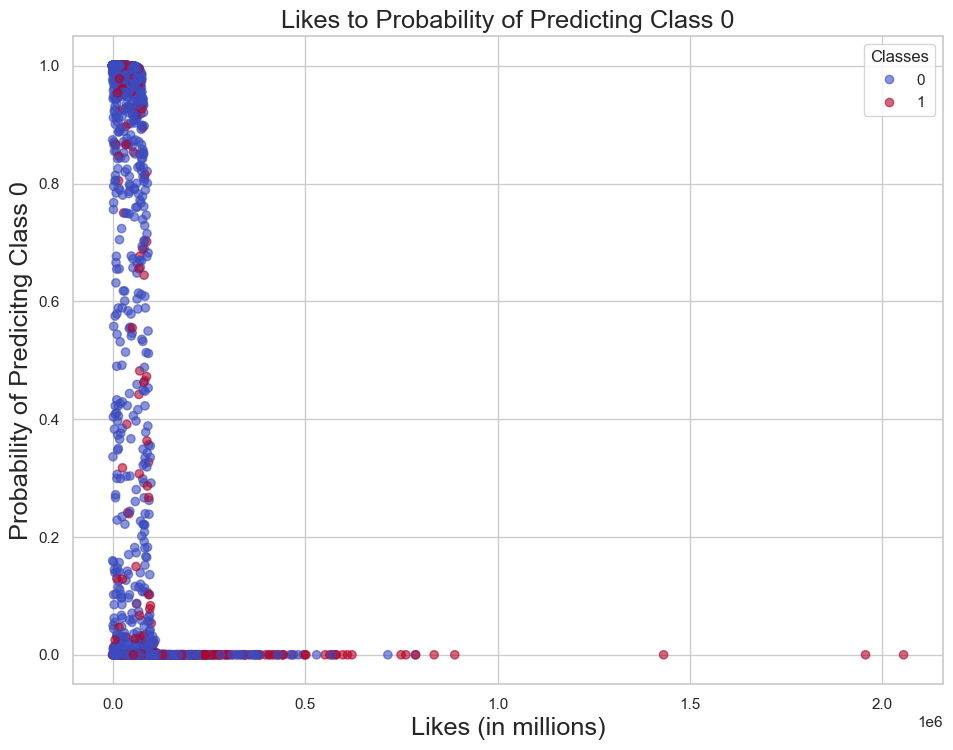

In [90]:
xrange = [i for i in range(len(GNB_probs[:,0]))]

plt.figure(figsize=(10, 8), dpi=100)

scatter = plt.scatter(X_test['likes'], GNB_probs[:,0], 
                        c=y_test, 
                        cmap='coolwarm',
                        alpha=0.6)
plt.title('Likes to Probability of Predicting Class 0', fontsize='small')
plt.xlabel('Likes (in millions)', fontsize='small')
plt.ylabel('Probability of Predicitng Class 0', fontsize='small')
plt.rcParams.update({'font.size': 22})


plt.legend(*scatter.legend_elements(), loc='upper right', title='Classes')
# ax.legend()

plt.show()

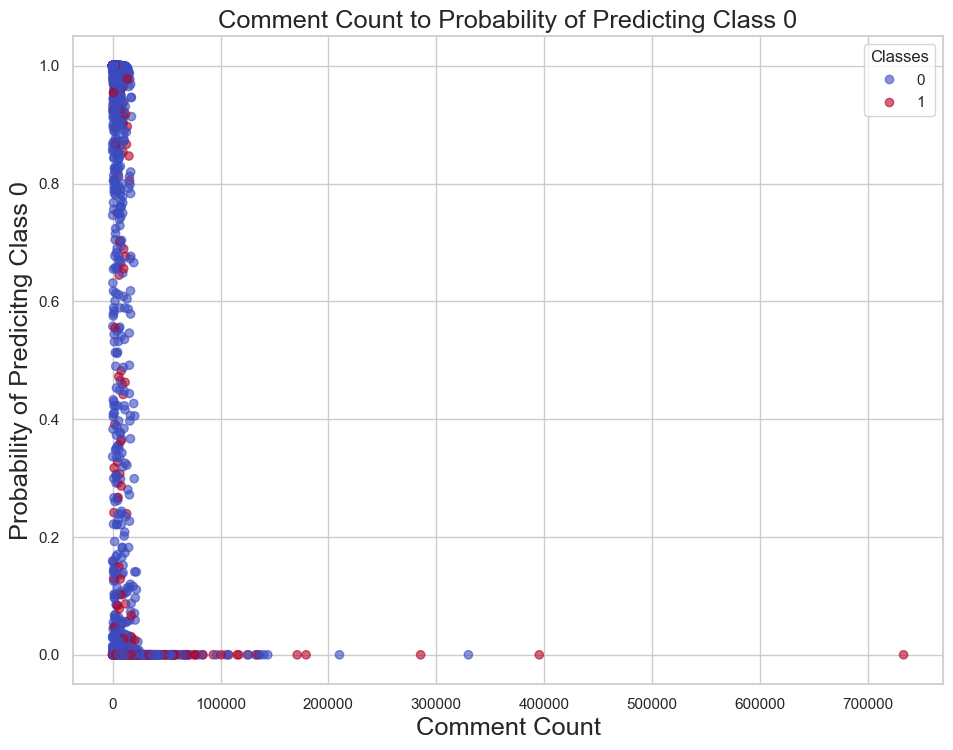

In [92]:
xrange = [i for i in range(len(GNB_probs[:,0]))]

plt.figure(figsize=(10, 8), dpi=100)

scatter = plt.scatter(X_test['comment_count'], GNB_probs[:,0], 
                        c=y_test, 
                        cmap='coolwarm',
                        alpha=0.6)
plt.title('Comment Count to Probability of Predicting Class 0', fontsize='small')
plt.xlabel('Comment Count', fontsize='small')
plt.ylabel('Probability of Predicitng Class 0', fontsize='small')
plt.rcParams.update({'font.size': 22})


plt.legend(*scatter.legend_elements(), loc='upper right', title='Classes')
# ax.legend()

plt.show()

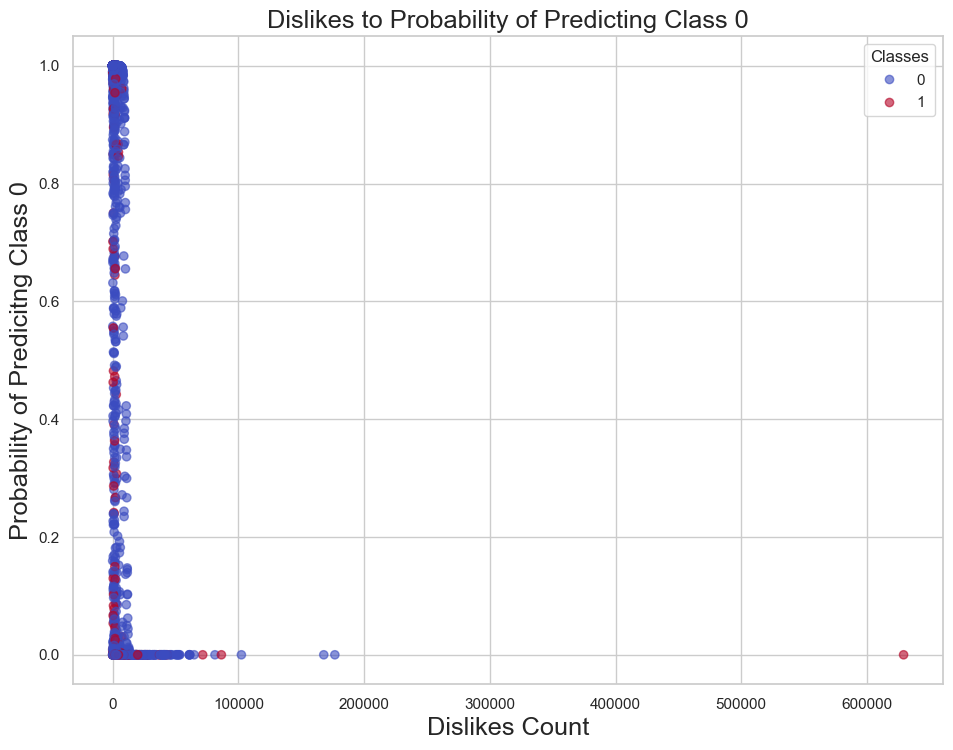

In [93]:
xrange = [i for i in range(len(GNB_probs[:,0]))]

plt.figure(figsize=(10, 8), dpi=100)

scatter = plt.scatter(X_test['dislikes'], GNB_probs[:,0], 
                        c=y_test, 
                        cmap='coolwarm',
                        alpha=0.6)
plt.title('Dislikes to Probability of Predicting Class 0', fontsize='small')
plt.xlabel('Dislikes Count', fontsize='small')
plt.ylabel('Probability of Predicitng Class 0', fontsize='small')
plt.rcParams.update({'font.size': 22})


plt.legend(*scatter.legend_elements(), loc='upper right', title='Classes')
# ax.legend()

plt.show()

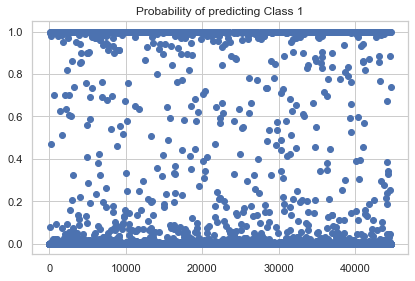

In [58]:
# xrange = [i for i in range(len(GNB_probs[:,0]))]
plt.scatter(xrange, GNB_probs[:,1])
plt.title('Probability of predicting Class 1')

plt.show()

## Histogram to show quantity of predictions to probability

In [40]:
from numpy import arange
bins = [i for i in arange(0.0, 1.0, 0.1)]
bins 

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9]

In [41]:
import numpy as np

In [46]:
bins = np.linspace(0.0,1.0, num=11)
bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

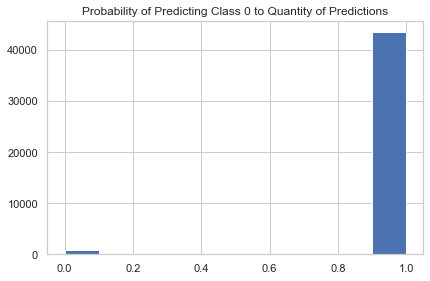

In [47]:
plt.hist(GNB_probs[:,0], bins)
plt.title('Probability of Predicting Class 0 to Quantity of Predictions')

plt.show()

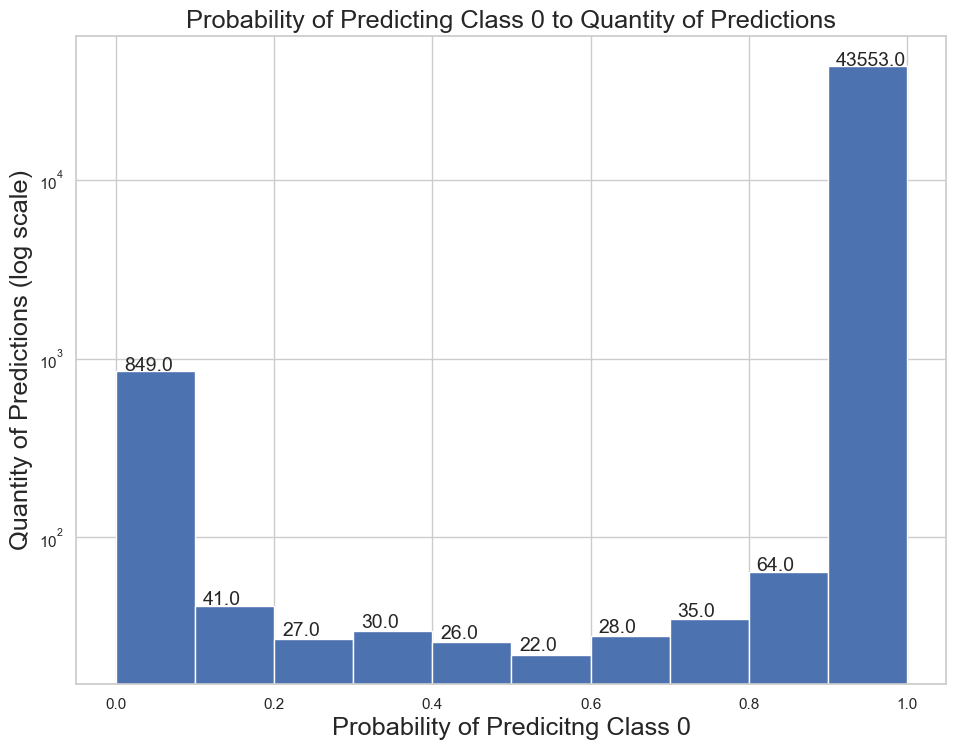

In [125]:
bins2 = 10

plt.figure(figsize=(10, 8), dpi=100)

arr = plt.hist(GNB_probs[:,0], bins2,
#                c=,
              )

# plt.ylim(0,1000)
plt.yscale('log')
plt.title('Probability of Predicting Class 0 to Quantity of Predictions',fontsize='small')
plt.xlabel('Probability of Predicitng Class 0', fontsize='small')
plt.ylabel('Quantity of Predictions (log scale)', fontsize='small')
plt.rcParams.update({'font.size': 22})

for i in range(bins2):
    plt.text(arr[1][i]+0.01,
             arr[0][i]+1,
             str(arr[0][i]), 
             fontsize=14, 
            )
    plt.text(arr[1][i],
             arr[0][i]/1.5,
             str(), 
             fontsize=14, 
            )


plt.show()

In [124]:
arr

(array([8.4900e+02, 4.1000e+01, 2.7000e+01, 3.0000e+01, 2.6000e+01,
        2.2000e+01, 2.8000e+01, 3.5000e+01, 6.4000e+01, 4.3553e+04]),
 array([0.        , 0.09999642, 0.19999284, 0.29998926, 0.39998568,
        0.4999821 , 0.59997852, 0.69997494, 0.79997136, 0.89996778,
        0.9999642 ]),
 <BarContainer object of 10 artists>)

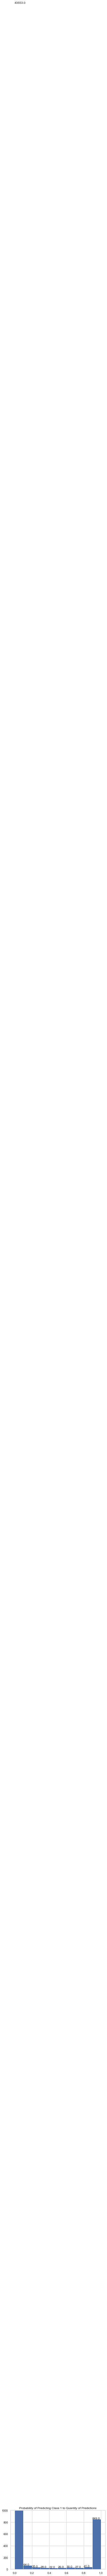

In [64]:
bins2 = 10
arr = plt.hist(GNB_probs[:,1], bins2)
plt.title('Probability of Predicting Class 1 to Quantity of Predictions')
plt.ylim(0,1000)
for i in range(bins2):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
plt.show()

## Calibration Curves

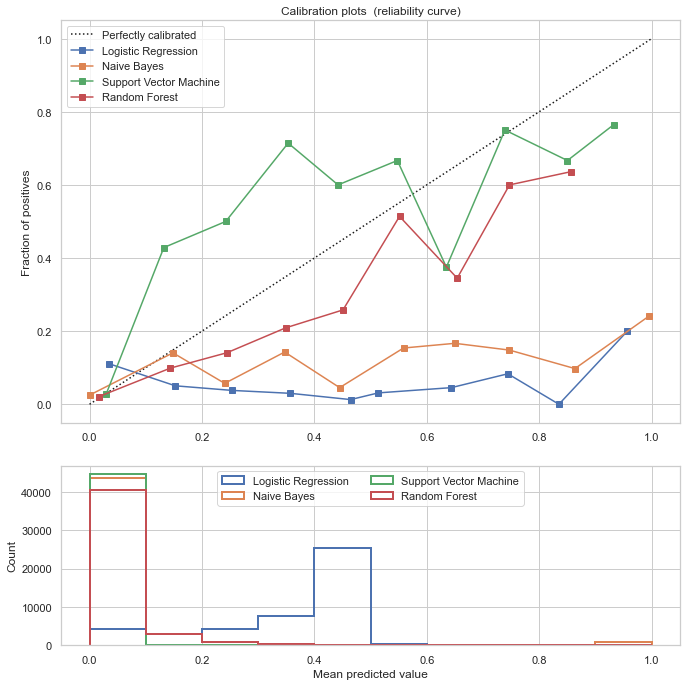

In [151]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(clf_log, 'Logistic Regression'),
                  (GNB, 'Naive Bayes'),
                  (clf_svm_rbf, 'Support Vector Machine'),
                  (clf_rdf, 'Random Forest')]:
    
#     Already trained
#     clf.fit(X_train, y_train)

    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="upper left")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [20]:
count = 0
for val in GNB_probs[:,1]:
    if val >= 0.9:
        count += 1
        print(val)

print(f"# of val above 0.9 = {count}")
print(f"% of val above 0.9 = {count/len(GNB_probs[:,1])}")

0.9946945808752582
0.9999390581907789
1.0
0.9999612251988033
1.0
0.9779608946754065
0.9965353269348017
1.0
0.9999774345216136
0.9999999998192024
1.0
0.999884975358085
1.0
0.9999999999999929
1.0
1.0
0.9999999999791669
0.9976079858524912
0.992611445204292
1.0
0.9776359789950628
0.9997557988355487
0.9999999999950901
1.0
0.9999961893652541
0.9981059394906774
1.0
0.9999994479269635
0.9999999999240572
0.998998216243904
1.0
0.9921825441627146
0.9999999999644871
0.9999999787475462
0.9999999999986287
1.0
0.9828492252357773
0.9999999999998721
1.0
0.9967989638091757
0.9502023486008395
1.0
1.0
1.0
0.9999997500186196
0.9999806362055108
0.9999999983405132
1.0
1.0
0.9999999999997868
0.9916668356296278
0.9999999984554293
0.9676678435199536
0.9999999523424148
0.990038528558318
0.999999659566954
1.0
1.0
1.0
0.9999999999987921
0.9999988918680203
0.9999999999990976
1.0
1.0
1.0
0.9999999998983427
1.0
1.0
1.0
1.0
0.9998857009675408
0.9999999999999147
0.9526127349329861
0.9999999999999858
0.9993105074943016


In [21]:
# fig, ax = plt.subplots()

# x_val=len(GNB_probs)

# ax.bar(x_val, GNB_probs[:,0])


# ax.set_ylabel('Probability')
# ax.set_title('Probability of x_i being in class 0')
# plt.show()

In [22]:
count = 0
for val in GNB_probs[:,0]:
    if 0.8 > val > 0.2:
        count += 1
        print(val)

print(f"# of val around 0.5 = {count}")

0.5313009079735511
0.2986362749623305
0.3761078508523502
0.4897592123632969
0.29902407992164654
0.3666816512606012
0.29948757702471085
0.39120794390235136
0.3968722232362767
0.7918497173883419
0.6764707145101211
0.26213940256437424
0.77795133959868
0.24142040254775574
0.5888738075960958
0.441934056596483
0.7148458918320933
0.30628662159838443
0.4105469758301091
0.26649702407312975
0.767137944132495
0.6174123877543661
0.5749667166903683
0.6762486225345712
0.30726207550258355
0.23948604427789177
0.7388656863352253
0.3219343935047197
0.4589465013569462
0.3034210941696149
0.5412469079314483
0.4434604624807761
0.48188031892757793
0.32715992262037735
0.6643972407298976
0.42256942363186906
0.7500083369178604
0.2436540889377728
0.3490087995217405
0.3660010618917253
0.7495895328685551
0.7023873613104943
0.7869541669101832
0.49151123788520196
0.7986715377357028
0.20153067390102125
0.644440050678691
0.6822388528869746
0.5838589651934732
0.7675415305689778
0.35656367968400954
0.5115043427774493
0.

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve

In [59]:
 GNB.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [24]:
GNB_predicted = GNB.predict(X_test)
GNB_precision = precision_score(y_test, GNB_predicted)
GNB_recall = recall_score(y_test, GNB_predicted)
GNB_f1 = f1_score(y_test, GNB_predicted)

print(f'Precision Score: {GNB_precision}')
print(f'Recall Score: {GNB_recall}')
print(f'F1 Score: {GNB_f1}')

Precision Score: 0.22816032887975335
Recall Score: 0.1661676646706587
F1 Score: 0.19229103508012127


### Classifier 1b: Bernoulli Naive Bayes

In [75]:
%%time
BNB = BernoulliNB()
BNB.fit(X_train, y_train)

Wall time: 1.51 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [76]:
%%time
BNB.score(X_test, y_test)

Wall time: 13 ms


0.9700951315053161

In [77]:
%%time
from sklearn.model_selection import cross_val_score

BNB_cvs = cross_val_score(BNB, X, y, 
                          cv=10, 
                          n_jobs=-1,)

print(f"GaussianNB 10-CV score: {BNB_cvs}")
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(BNB_cvs)}")

GaussianNB 10-CV score: [0.97011752 0.97011752 0.97011752 0.97011752 0.97011752 0.97011752
 0.97017348 0.97017348 0.97017348 0.97017181]
GaussianNB 10-fold Cross Val Avg: 0.9701397323548177
Wall time: 2.66 s


In [96]:
BNB_predicted = BNB.predict(X_test)
BNB_precision = precision_score(y_test, BNB_predicted)
BNB_recall = recall_score(y_test, BNB_predicted)
BNB_f1 = f1_score(y_test, BNB_predicted)

print(f'Predicted Array: {BNB_predicted}')
print(f'Precision Score: {BNB_precision}')
print(f'Recall Score: {BNB_recall}')
print(f'F1 Score: {BNB_f1}')

Predicted Array: [0 0 0 ... 0 0 0]
Precision Score: 0.0
Recall Score: 0.0
F1 Score: 0.0


### Classifier 2: Logistic Regression

In [130]:
from sklearn.linear_model import LogisticRegression

In [131]:
%%time
clf_log = LogisticRegression(random_state=42,
                            verbose=2,
                            n_jobs=-1,)
clf_log.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished


Wall time: 3.2 s


LogisticRegression(n_jobs=-1, random_state=42, verbose=2)

In [146]:
%%time
clf_log.score(X_test,y_test)

Wall time: 16.6 ms


0.9639395635142697

In [84]:
%%time
from sklearn.model_selection import cross_val_score

clf_log_cvs = cross_val_score(clf_log, X, y, 
                              cv=10, 
                              n_jobs=-1,)

print(f"GaussianNB 10-CV score: {clf_log_cvs}")
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(clf_log_cvs)}")

GaussianNB 10-CV score: [0.96849468 0.97011752 0.96603246 0.96575266 0.96950196 0.96838276
 0.95719082 0.97022943 0.95299384 0.96155353]
GaussianNB 10-fold Cross Val Avg: 0.9650249667237182
Wall time: 4.06 s


In [85]:
clf_log_predicted = clf_log.predict(X_test)
clf_log_precision = precision_score(y_test, clf_log_predicted)
clf_log_recall = recall_score(y_test, clf_log_predicted)
clf_log_f1 = f1_score(y_test, clf_log_predicted)

print(f'Predicted Array: {clf_log_predicted}')
print(f'Precision Score: {clf_log_precision}')
print(f'Recall Score: {clf_log_recall}')
print(f'F1 Score: {clf_log_f1}')

Predicted Array: [0 0 0 ... 0 0 0]
Precision Score: 0.037037037037037035
Recall Score: 0.008233532934131737
F1 Score: 0.013472137170851195


In [44]:
log_probs = clf_log.predict_proba(X_test)

In [45]:
print(f"min of left col = {min(log_probs[:,0])}, max of right col = {max(log_probs[:,1])}")
print(f"max of left col = {max(log_probs[:,0])}, min of right col = {min(log_probs[:,1])}")

min of left col = 0.0005040897730003158, max of right col = 0.9994959102269997
max of left col = 1.0, min of right col = 1.702761423536652e-108


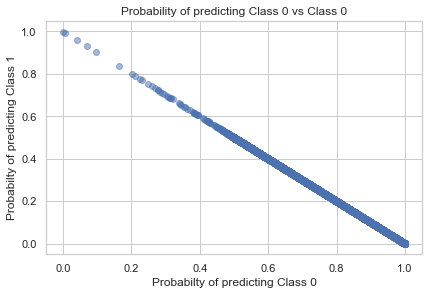

In [46]:
fig, ax = plt.subplots()
plt.scatter(log_probs[:,0], log_probs[:,1], alpha=0.5)

plt.title('Probability of predicting Class 0 vs Class 0')
ax.set_xlabel('Probabilty of predicting Class 0')
ax.set_ylabel('Probabilty of predicting Class 1')

plt.show()

In [48]:
count = 0
for val in log_probs[:,0]:
    if 0.8 > val > 0.2:
        count += 1
        print(val)

print(f"# of val around 0.5 = {count}")

0.5022338505657401
0.5311821193651218
0.5611569116958128
0.6253934614570564
0.6919687956670371
0.566743033707509
0.6622691348716656
0.5748743874223813
0.5761117009678203
0.581733650090111
0.671181168050345
0.6548808981827099
0.6441751678660916
0.5462048731241496
0.591740590115047
0.5048370311362285
0.5903619507406437
0.7920867837324153
0.5087359729641039
0.5142399739663319
0.5401207080535121
0.5152926352486922
0.5289738049988798
0.5239304929842721
0.5372199593401581
0.5278858770605663
0.5123322319445647
0.6184831700782403
0.6304089020190202
0.5488949055604508
0.5046413252520034
0.5619676930358137
0.5032701613721801
0.7346972700952403
0.5692085858053815
0.5198193875857122
0.7296803704139551
0.5374483851632154
0.5201922847161873
0.544051677384332
0.6910600149608492
0.6534204683936633
0.505506583206065
0.6973184380108964
0.5432490822104998
0.6240859288769453
0.6703515983044426
0.5224847245025914
0.7095316883088045
0.7199144288647844
0.5062907866781894
0.7064950547709814
0.7267520886972166

0.6484423012059404
0.6701303814707458
0.5133650523348664
0.5194684786778081
0.5667530009024723
0.7966443639987387
0.6772040558865149
0.6848016458348941
0.5268878198580114
0.6116492395576596
0.5091628119427414
0.5151212307529911
0.5539326873449555
0.5891326930752656
0.5969751590575016
0.5347429509363474
0.5663773962714392
0.512050001419548
0.543460552261559
0.5197171360793007
0.6552992150936011
0.5498846774867372
0.67468159319484
0.5211098734624191
0.6386223067397814
0.6630044334652994
0.7764733660257892
0.5051423731461118
0.6668074027498174
0.5053557877863628
0.5893739251721348
0.6477065578950221
0.5302309599826627
0.5700431524502771
0.5308403361681999
0.5868496187813887
0.5053111841375479
0.5480513052651704
0.7086904613839233
0.6005532887815099
0.5199983190720698
0.5188201582118253
0.7090837611432712
0.6992518581678349
0.7720129554746213
0.5028562221845034
0.522131351466671
0.5491777090562833
0.5500650206653606
0.5709921269799365
0.6732863724200108
0.5290988000214059
0.529151096377523

0.5555356329673449
0.6314433503941586
0.6618987541871846
0.5936557873607258
0.7459643400720123
0.5134576661020702
0.5715939687018934
0.6178209072914853
0.5246721897144311
0.5067352155374307
0.516451842503777
0.6118816476896034
0.5195226829595045
0.5022786347837678
0.5736861693675528
0.6663394631696693
0.5171663032016374
0.5889164416006744
0.5655947906796315
0.5107011254219378
0.6792064171611698
0.49860201199084264
0.5183621100849509
0.5544832107084046
0.5120868099291954
0.5324653913225892
0.6674657413347225
0.5026364372053347
0.5986033911009049
0.6956960252393043
0.5704699593194152
0.6173395401475528
0.7684578886537201
0.6886600425864011
0.5036410476600188
0.5608468769394432
0.5464680459553022
0.5300463664369593
0.5072064541984815
0.6755636088247354
0.5561288176632231
0.7343011309912589
0.6603318910821996
0.5307996264444375
0.5894850489787002
0.5318708128696951
0.5012445406173389
0.5204653425715877
0.5024471494789293
0.5184421685118715
0.7326803995165638
0.6413956717272922
0.5067050961

0.5710088132362434
0.5911367373515084
0.6073742487275264
0.5636960620918388
0.5004232294430144
0.6990276435162999
0.5215842001113125
0.5531593477292676
0.5063570357639826
0.5124959904526772
0.5432491939388682
0.5897900560935803
0.5109373983717933
0.7644417073169096
0.5053358959153934
0.5292981806720194
0.5333177917242459
0.5139416076172585
0.5856077172950791
0.5036427409527486
0.5831210498186857
0.6417238783336603
0.5533536966823059
0.5184346814517133
0.5263223224360893
0.5764225612436059
0.5454399437889261
0.5042825922198897
0.6056616388700424
0.5031168380003916
0.5351012841709623
0.5066866340692285
0.5080499451116751
0.5868300348337333
0.5083434390142794
0.5232515712024239
0.5126242349215728
0.5188662844114698
0.5480835187189774
0.5796145043201875
0.528379989327328
0.5203917669216845
0.6638368243683019
0.6035584091299249
0.5019470721624438
0.5410230247553807
0.5415930104808888
0.5334492745549119
0.568974348795281
0.5143105242330124
0.6022085295075241
0.5552729784469377
0.529864491494

0.7875122754663291
0.5076925678108674
0.5047773166378053
0.6322487407028609
0.5496258644981105
0.5313575625712359
0.7229067534844361
0.744701642889783
0.512304558776336
0.5900187322794661
0.5810933864682404
0.618302540681755
0.7926661364545533
0.5342201901641974
0.6527001090724476
0.549308817968587
0.5411041773950647
0.5872349037947682
0.5938186206204991
0.6555603063611914
0.6720253507505711
0.5074833266008529
0.6711667640971768
0.7498580646151669
0.5413592961107697
0.512549942819611
0.5459683042563919
0.6286442126713114
0.5624948976189368
0.5224376721645909
0.5768089451410242
0.5813234597160295
0.7230106237703646
0.7130963286599137
0.50835402627307
0.7584174224805058
0.5298161652978153
0.5318546708209964
0.5276989646985883
0.5212529558528003
0.6995724566973821
0.536635522102386
0.5164916451307615
0.6350085224159657
0.5554569553469656
0.5799396865190143
0.7872662723989814
0.5718510793501215
0.7371913344943077
0.5717665847397645
0.5581513067580813
0.5433626160823597
0.5664636063116295
0

0.536140001148331
0.7249583238811688
0.6286451036580574
0.5482211132852075
0.5454816326469172
0.5095801846426291
0.6469185712535646
0.5439411248007875
0.6619174676145392
0.5727729926637954
0.5455766904511488
0.7481224659480471
0.5134875011010622
0.5222581554541077
0.6601316250620035
0.5386828909429286
0.5077970620686914
0.6833465336869211
0.5182755203498135
0.5922664174674581
0.558752320153919
0.6335174365565159
0.7247432479820572
0.547506715235859
0.6529622819945287
0.5862702887460156
0.5442941088551101
0.5026633178688591
0.6451999956744215
0.5533043828859372
0.5046855745615964
0.5805798470510792
0.5618456193410382
0.7445526135047782
0.5261984770580159
0.6103541188395064
0.6001547820641717
0.595639256322399
0.5250879235082933
0.5537790881152418
0.6198006674402194
0.697278865993013
0.5045996844735011
0.5455203312828195
0.5033540415398654
0.5136186189556281
0.5081571414281857
0.5273531097231249
0.5033965220327854
0.6169600904367666
0.5075773748483932
0.5566520699177193
0.704154427236923

0.5833941197639186
0.5510554136238885
0.6707578522676951
0.6440855403577019
0.5116646962274465
0.5031477209049758
0.5104149639321736
0.5063888036237532
0.5833995890567059
0.5521668844464183
0.6985307064969235
0.6859431810594665
0.685074910863753
0.6169668460218455
0.5388451697544903
0.5210447667338262
0.5497771316196955
0.6413564547075534
0.5238592621887616
0.5466658863771748
0.5078717297260705
0.5039768621842704
0.5069103353074145
0.5684230532730588
0.6276066731550215
0.5024254077975647
0.5212447409216349
0.5089783879074358
0.5112542229504922
0.7529810598900075
0.6128370684108448
0.5109699866342674
0.5058629056882289
0.5241364508314676
0.5040436321587769
0.6494579804314298
0.7627759033202519
0.5119256210472745
0.6171421634742906
0.5624283114327475
0.5454329521027798
0.5761210353343713
0.7196917502018814
0.5236537723214477
0.6333619079561345
0.520822795796303
0.5098517322278511
0.5039992483584109
0.4967411895072812
0.5776092882001453
0.5569631003972627
0.7525265587042078
0.564681336295

0.5105957751526106
0.654549297276331
0.5076971638740136
0.5699048334061767
0.6358169830427094
0.6308967172155304
0.5029975635726807
0.5597628321600748
0.6114228844269952
0.526871004540552
0.5080924990060756
0.5380728925089284
0.5153660908161297
0.5872801545644941
0.5561836941236813
0.5977232868225454
0.7276774719748793
0.5705557456253685
0.5986043419800262
0.6090610358307943
0.6646298024076555
0.5589765752525526
0.5296263427801533
0.7931865082967198
0.5253145390760281
0.5933673722289072
0.7175531174094241
0.5109822540862439
0.5717783727994985
0.5380644173121163
0.5901919783524259
0.6455113382032718
0.5820885367886894
0.544883426425522
0.5851506413997367
0.6229637220342963
0.719289441783671
0.5629596291360526
0.5399503691233394
0.5737289801374981
0.5511167864267426
0.604404541494941
0.5671570711377016
0.5979176755976914
0.49988777582603183
0.5054708077750771
0.5228211819482896
0.5247744070336886
0.5282131835529496
0.506538443010002
0.5210796841877039
0.5118338731138947
0.502951754210719

0.7285699423121056
0.5091739753306901
0.5492620790291135
0.5070016866256628
0.5082480716902691
0.5765457810373765
0.5687014378805351
0.5547673049063895
0.5362064882687385
0.5033354661773467
0.5186499653128829
0.5055110617465611
0.6147545377334623
0.5025622274018253
0.5721300390943096
0.5647860037179565
0.5060595610469847
0.7324294704342655
0.5682756035153891
0.5460430736294009
0.5459601988364964
0.6643411350231216
0.5745091758137563
0.7606595659387585
0.7737939487313472
0.5057589421619543
0.5098914834377519
0.7726843268339745
0.5432829779201331
0.497047658132428
0.7006079644098309
0.5586715454965664
0.5989505701057152
0.7589210607751957
0.5134951847023548
0.5111156649509322
0.5103603648586141
0.5067783651868412
0.5069969832019274
0.6186362085676043
0.747356692931117
0.6688678450653983
0.5863002593542048
0.6785202991843194
0.5872755499254638
0.6478066627670529
0.7814549744209817
0.5298391220336038
0.5274080423324792
0.5214572075876134
0.6896260869978015
0.5453410889136545
0.513583878706

0.5430321624202943
0.5994273479084002
0.5649615122539482
0.65413878570144
0.5480377737587665
0.5868531167684374
0.7271524716952289
0.7655964280680578
0.5065991042779541
0.6044877141329117
0.5120149419425508
0.5187433327296981
0.5021424636756122
0.6896607994329527
0.7224915881023926
0.542618133426105
0.596612935386822
0.7805258191390335
0.7984727272446125
0.6052219930483664
0.5061073583152873
0.5059536034261285
0.675337004091497
0.5162258772437707
0.5512069586655609
0.5066112424957478
0.6377087564678634
0.5471512855016106
0.6250386805897143
0.6455648200703842
0.6346016098698213
0.7886744272408094
0.5286454589519258
0.5572756718102326
0.571549657340643
0.5527204721980441
0.6405969747371631
0.7616660963615588
0.6547292092639176
0.5095235116503576
0.5281248649341928
0.6372086314642214
0.5053861878184843
0.6366810633480708
0.5826292752919116
0.5923313992261644
0.5039765186869043
0.5054608865020509
0.6731487510250506
0.7271837784560867
0.22555740348812847
0.586237512526305
0.5057712348358874

0.5053951992195993
0.5046416025165628
0.6088453874530347
0.5590396513418114
0.6371400614560055
0.572943971363534
0.6224676896175916
0.6044694262154825
0.6400487489112283
0.5660369487813418
0.5171815453074919
0.6134052440556332
0.489611585537331
0.557031425980423
0.6161338394393469
0.524124957122329
0.5127293226453529
0.509839335578463
0.5373598472682228
0.5446969340006041
0.5349408039151393
0.5265004850204081
0.5137584560229512
0.5040032254761455
0.5123806069473751
0.5270591431952389
0.509700500093865
0.5150573085954958
0.5200419946477448
0.5227825091448028
0.5625111648329548
0.5474562572426118
0.5139682861470795
0.5148533834917082
0.6318431232074464
0.6971635639374196
0.6722022963855804
0.5709201968970554
0.5843031133387014
0.5334165304897412
0.539361321964291
0.5649894645923754
0.5422603592158735
0.5077780989493135
0.6181020223519202
0.5532294107093151
0.5313408719022957
0.5460710869771693
0.6043225383700012
0.7813092857387991
0.5190621030241098
0.6229779112225367
0.5160520011037719


0.6287260594956661
0.6466790064136252
0.5001507300839729
0.533771946614894
0.5135204589289302
0.5140881231348187
0.5432419407704469
0.5366989541120768
0.5618211633895192
0.5282075822563302
0.5976865194091097
0.6484669432795844
0.5416149072976112
0.5624908789635092
0.5486446918425716
0.6353218659298078
0.5047064949413227
0.5017721887933106
0.5151296128309711
0.6598238923851565
0.6214860946738532
0.5470772313321628
0.53941091293057
0.5167664188254321
0.5724999341203193
0.5061125753319673
0.7783175426975247
0.504268117348202
0.7274189296974372
0.5535281454794307
0.591516409432955
0.580919092158246
0.5331104034027958
0.5558659353997975
0.5385230237554179
0.5135061703558016
0.5050044770669109
0.7828405511870573
0.5699490631458559
0.5074155153334279
0.5126026463732954
0.63139440288592
0.5096238499823305
0.5426348381688876
0.5530965160298958
0.5032340345667101
0.7383754020446569
0.786226205870602
0.5976060581036404
0.597691557675729
0.6167436698828873
0.510299760799232
0.5110987282837665
0.63

0.5199284802119069
0.5175439687168049
0.7051494016027308
0.5110579482082424
0.6560641822057569
0.5073509650151915
0.5282968348753994
0.742293299149726
0.7520280564015113
0.5191770472972357
0.5448843168176803
0.5033319903336761
0.5345420506115399
0.5169183584797781
0.5318954386744152
0.6077655239159286
0.5072841768396688
0.6289191199903112
0.5051368165382892
0.5152556316612903
0.7710356216710801
0.6497852589807882
0.5048068010068545
0.5360495933928051
0.5849409333669888
0.5582666641479015
0.5184317265904519
0.5060701338129776
0.541430657147157
0.5286325435805135
0.5717579906212356
0.5566107345095841
0.7840221587397292
0.5746690897287832
0.6233891031428684
0.5678315081761947
0.5060685592320302
0.6334276505424811
0.7699726984400181
0.5065561989417584
0.5187792450285935
0.5555773748152555
0.6833962690485409
0.618636432953897
0.5059271473010336
0.5471033302862425
0.5110196308490672
0.5385822881848445
0.5444257797898868
0.54305607526981
0.5102342161511713
0.6588337946685554
0.592006298817358

0.5528590453095203
0.5076573558650908
0.6534260561625711
0.7364076000713642
0.5202317189914516
0.7103259500668668
0.5436437022834357
0.5318245435192839
0.5677704203366225
0.7784374718227213
0.6541730101839396
0.679399156310073
0.502714558522261
0.6404118617644029
0.6845899305845697
0.7580253661656037
0.7922982838474395
0.5439369093139972
0.5662764062833334
0.665813620883103
0.5093851905438009
0.5119751751311452
0.5410072546524511
0.6360821200756664
0.5675299810273373
0.5273613238770193
0.7090712804221424
0.5199980903122613
0.5042368927463042
0.6212916527753669
0.5037189343538955
0.5115416101997707
0.5299379943592276
0.614851108102376
0.5527526563024436
0.6906336864339128
0.5402077431964167
0.5067540768866159
0.5197256537393045
0.614698417421453
0.6286945987988992
0.5062956179576855
0.7260146385169906
0.5530031219380831
0.5067968473326826
0.5323835709694824
0.6351767102641486
0.5169777607134896
0.5699159754727842
0.534729422183587
0.5779232244996867
0.7335893477700526
0.6338171505671194

0.5321229650372112
0.5302621528140968
0.5753677964295325
0.5430531409729528
0.511712530767823
0.5582089537223285
0.6115845022434556
0.7746622646908747
0.566015656325101
0.6335871185305284
0.50457491087144
0.642611764138032
0.7069739946277038
0.6791230483556758
0.5968746182384659
0.5325768658410296
0.5894524053563093
0.5094150948322773
0.510332847692548
0.5886441757957517
0.7145771130096337
0.5473033089358079
0.5649007717891918
0.6895363361161191
0.520449091189928
0.5197507133046735
0.6058329776072917
0.509062047899812
0.611390291785294
0.5030654758672934
0.5571736279162216
0.551137619894995
0.5003478693209708
0.5051766928342518
0.5189376677780974
0.5393248959066619
0.6418319274950264
0.5052381760320714
0.5560263262014278
0.6103487879197695
0.5018729145900084
0.6070383053330628
0.7008896866975516
0.5268464195822642
0.5044275442088602
0.5181047303777254
0.5022928279146435
0.5044081695087856
0.510749935303471
0.5301057942211922
0.5221591386323878
0.5380397963508268
0.5232277665160456
0.66

0.6298862607634033
0.6593455562129378
0.5187846626719361
0.7564244488525461
0.5249620597451201
0.6660878262206553
0.505615121833137
0.6899093355419705
0.5349667153787043
0.6690932040040305
0.5971749223665925
0.5122155156579166
0.5904562694028069
0.75171347023787
0.5147072090518681
0.5320624845699073
0.655774509452487
0.6406252466966162
0.6175721281603672
0.7136212367535644
0.5181398409751234
0.5914853831167268
0.5623626938867557
0.7449335260508472
0.5248096922460664
0.5985109395198382
0.7693035009591892
0.5997462082014746
0.7137256677226114
0.5031072407451387
0.785766642244369
0.509401811561486
0.7616257154307919
0.5049082358206907
0.7093932725879869
0.5623642452997997
0.6461399213408747
0.6243870448975861
0.5517920406136678
0.509825129704248
0.5762068010285544
0.5017399413202488
0.49946606514124625
0.514668183481247
0.5172843642941842
0.5549818449466445
0.5334132792475854
0.5061323430460315
0.5047861700798375
0.5072100625339749
0.5022347747205311
0.5508031752675813
0.6427394816462184


0.6272911669047917
0.7538440369519476
0.5896612038703295
0.4998085318557426
0.7976734483825093
0.51498847063876
0.5058388609143656
0.774931896610085
0.6275837098181465
0.5341102552131654
0.5050348013880297
0.5025553285338882
0.5773998418976991
0.7056530719161521
0.7549263770475717
0.5386244021931437
0.5381099228309874
0.759639094623882
0.5618559828779672
0.687658205654144
0.5425318960455765
0.5547765423838726
0.5515594618328039
0.627350843285575
0.7366118637968577
0.7100890186730331
0.5300240492438907
0.6208669671185225
0.7205787664408507
0.6601472680965981
0.5033814645413608
0.6383159994540348
0.5479168054336605
0.543118469256997
0.5147209201394408
0.5550050501930555
0.6183014092193763
0.5104858733098585
0.5910137098526849
0.6484203769686252
0.5236277676010014
0.72709380716626
0.5250367141893533
0.5592300369540742
0.6613025535847439
0.5962264569340762
0.6363443741353114
0.7017863775777141
0.5567785094380248
0.5060508733362878
0.5075887971255979
0.548802829733429
0.517881528218739
0.54

0.710437008343079
0.7982789198287149
0.6491105393476255
0.5065975029680052
0.5819288331555401
0.5025995158973627
0.5258895802296811
0.504015439247344
0.5060758749914263
0.5868346399774297
0.547840814416076
0.6733535298056492
0.6496066905929141
0.6437965416935411
0.6315642533691654
0.5546720413141045
0.5086494840908901
0.5228860559639007
0.5251896018559921
0.5904875001599719
0.6149041808809079
0.6216684819693976
0.5369722609137657
0.506244916470082
0.7597346225618444
0.6171747114162249
0.5172319535184224
0.5402658692197436
0.5231998868757879
0.578611899073587
0.5079061854920393
0.6335240250612648
0.5267090770171776
0.5274051919092956
0.5147467668364378
0.6745890065797678
0.5124044893014744
0.599600068489334
0.5796548754108762
0.5865020807155512
0.5154719985794722
0.5088946770016067
0.5164701676417309
0.5067393106134725
0.5248585082680557
0.576623434311468
0.6557569569073326
0.773338090593237
0.6689993767571927
0.6901128736527039
0.5042626533768834
0.5048292891149544
0.5255805794486145
0

0.579182114291368
0.556796631667691
0.5637137589861165
0.6502262396980591
0.5065681260278166
0.5229869123007129
0.6067941385232569
0.502829597320197
0.7030603513719185
0.691915452549285
0.5302240864381305
0.6325343662460384
0.6507233486396999
0.5554838782385338
0.5283790325118598
0.5080474352669198
0.5159972059971392
0.5271068978734625
0.509107036076746
0.5351868684932248
0.548314213118524
0.5670121324276247
0.5704756575434478
0.5400899222832648
0.6032782716405235
0.5049256157725488
0.605930295826199
0.636594230663236
0.5876580433007181
0.5078396150880318
0.5449571169655036
0.7060250767800136
0.5529358477939416
0.5299889681799768
0.5357926671441846
0.506282006217204
0.6793248031383803
0.5067242619435557
0.5458826025569399
0.5169381070766801
0.5286449721964965
0.5786549770437837
0.7472948429727129
0.507633885340777
0.5411449229084575
0.5089200443262079
0.5288469323599656
0.536860313332481
0.5292256975088987
0.5543799003904264
0.6129703897054717
0.6342808740792742
0.5541193459611184
0.53

0.5049928431661073
0.6282138649424518
0.5951046392455337
0.6436473894294383
0.6314312626727883
0.5530512074728935
0.5565390084938917
0.607930201761957
0.6234964819693427
0.5674995189743954
0.6390179898936661
0.5366977518677913
0.6183965641724155
0.5547815093399185
0.5266360462242274
0.7818027490489766
0.563566714224578
0.6714970579788795
0.5406446991871343
0.5314361779018435
0.5527272893045679
0.7195321406836223
0.5275618923549891
0.6558898475559056
0.5202388653250727
0.5484283655553458
0.5725821854647217
0.5060822529419126
0.663464274875708
0.5841793206409984
0.6286034943475007
0.7580389234585478
0.6367724367392551
0.7082491438499217
0.5062997036132976
0.6978282838922583
0.5025760411261881
0.5049959540232345
0.5054470343860766
0.6451640249012842
0.5143190327167521
0.539846257352715
0.5034751985463644
0.5368505313912093
0.5388045266898311
0.709034926374723
0.5615359041405152
0.6087818440906593
0.6427476081201109
0.5312270916385678
0.5983625223533282
0.5711475790659404
0.554754179829717

In [51]:
count = 0
for val in log_probs[:,1]:
    if val >= 0.9:
        count += 1
        print(val)

print(f"# of val above 0.9 = {count}")
print(f"% of val above 0.9 = {count/len(log_probs[:,1])}")

0.9994959102269997
0.9933225448336405
0.9310513284418573
0.957680272506591
0.9028478809427349
# of val above 0.9 = 5
% of val above 0.9 = 0.0001119194180190263


### Classifier 3: Support Vector Machine (SVC)

In [25]:
from sklearn.svm import SVC, LinearSVC

In [26]:
%%time
clf_svm_rbf = SVC(probability=True,
                  kernel='rbf',
                  verbose=2,
                  random_state=42,)

clf_svm_rbf.fit(X_train,y_train)

[LibSVM]Wall time: 16min 41s


SVC(probability=True, random_state=42, verbose=2)

In [27]:
%%time
clf_svm_rbf.score(X_test,y_test)

Wall time: 32.3 s


0.9705428091773923

In [ ]:
# %%time
# clf_svm_rbf_cvs = cross_val_score(clf_svm_rbf, X, y, 
#                               cv=10, 
#                               n_jobs=-1,)

# print(f"GaussianNB 10-CV score: {clf_svm_rbf_cvs}")
# print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(clf_svm_rbf_cvs)}")

In [28]:
clf_svm_rbf_predicted = clf_svm_rbf.predict(X_test)
clf_svm_rbf_precision = precision_score(y_test, clf_svm_rbf_predicted)
clf_svm_rbf_recall = recall_score(y_test, clf_svm_rbf_predicted)
clf_svm_rbf_f1 = f1_score(y_test, clf_svm_rbf_predicted)

print(f'Precision Score: {clf_svm_rbf_precision}')
print(f'Recall Score: {clf_svm_rbf_recall}')
print(f'F1 Score: {clf_svm_rbf_f1}')

Precision Score: 0.6666666666666666
Recall Score: 0.029940119760479042
F1 Score: 0.05730659025787966


In [60]:
svm_rbf_probs = GNB.predict_proba(X_test)

In [61]:
print(f"min of left col = {min(svm_rbf_probs[:,0])}, max of right col = {max(svm_rbf_probs[:,1])}")
print(f"max of left col = {max(svm_rbf_probs[:,0])}, min of right col = {min(svm_rbf_probs[:,1])}")

min of left col = 0.0, max of right col = 1.0
max of left col = 0.999964201117343, min of right col = 3.579888265721081e-05


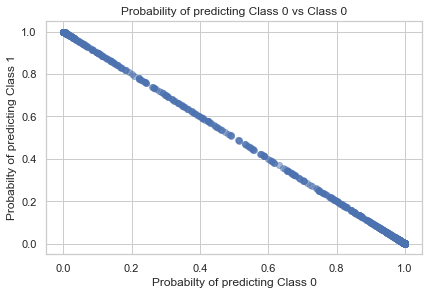

In [62]:
fig, ax = plt.subplots()
plt.scatter(svm_rbf_probs[:,0], svm_rbf_probs[:,1], alpha=0.5)

plt.title('Probability of predicting Class 0 vs Class 0')
ax.set_xlabel('Probabilty of predicting Class 0')
ax.set_ylabel('Probabilty of predicting Class 1')

plt.show()

In [64]:
count = 0
for val in svm_rbf_probs[:,0]:
    if 0.8 > val > 0.2:
        count += 1
        print(val)

print(f"# of val around 0.5 = {count}")
print(f"% of val around 0.5 = {count/len(svm_rbf_probs[:,1])}")

0.5313009079735511
0.2986362749623305
0.3761078508523502
0.4897592123632969
0.29902407992164654
0.3666816512606012
0.29948757702471085
0.39120794390235136
0.3968722232362767
0.7918497173883419
0.6764707145101211
0.26213940256437424
0.77795133959868
0.24142040254775574
0.5888738075960958
0.441934056596483
0.7148458918320933
0.30628662159838443
0.4105469758301091
0.26649702407312975
0.767137944132495
0.6174123877543661
0.5749667166903683
0.6762486225345712
0.30726207550258355
0.23948604427789177
0.7388656863352253
0.3219343935047197
0.4589465013569462
0.3034210941696149
0.5412469079314483
0.4434604624807761
0.48188031892757793
0.32715992262037735
0.6643972407298976
0.42256942363186906
0.7500083369178604
0.2436540889377728
0.3490087995217405
0.3660010618917253
0.7495895328685551
0.7023873613104943
0.7869541669101832
0.49151123788520196
0.7986715377357028
0.20153067390102125
0.644440050678691
0.6822388528869746
0.5838589651934732
0.7675415305689778
0.35656367968400954
0.5115043427774493
0.

In [65]:
count = 0
for val in svm_rbf_probs[:,1]:
    if val >= 0.9:
        count += 1
        print(val)

print(f"# of val above 0.9 = {count}")
print(f"% of val above 0.9 = {count/len(svm_rbf_probs[:,1])}")

0.9946945808752582
0.9999390581907789
1.0
0.9999612251988033
1.0
0.9779608946754065
0.9965353269348017
1.0
0.9999774345216136
0.9999999998192024
1.0
0.999884975358085
1.0
0.9999999999999929
1.0
1.0
0.9999999999791669
0.9976079858524912
0.992611445204292
1.0
0.9776359789950628
0.9997557988355487
0.9999999999950901
1.0
0.9999961893652541
0.9981059394906774
1.0
0.9999994479269635
0.9999999999240572
0.998998216243904
1.0
0.9921825441627146
0.9999999999644871
0.9999999787475462
0.9999999999986287
1.0
0.9828492252357773
0.9999999999998721
1.0
0.9967989638091757
0.9502023486008395
1.0
1.0
1.0
0.9999997500186196
0.9999806362055108
0.9999999983405132
1.0
1.0
0.9999999999997868
0.9916668356296278
0.9999999984554293
0.9676678435199536
0.9999999523424148
0.990038528558318
0.999999659566954
1.0
1.0
1.0
0.9999999999987921
0.9999988918680203
0.9999999999990976
1.0
1.0
1.0
0.9999999998983427
1.0
1.0
1.0
1.0
0.9998857009675408
0.9999999999999147
0.9526127349329861
0.9999999999999858
0.9993105074943016


### LinearSVC

In [29]:
%%time
from sklearn.svm import LinearSVC

clf_svm_lin = LinearSVC(
#                         probability=True,
                         verbose=2,
                         random_state=42,)

clf_svm_lin.fit(X_train,y_train)

[LibLinear]Wall time: 11.1 s


LinearSVC(random_state=42, verbose=2)

In [33]:
%%time
clf_svm_lin.score(X_test,y_test)

Wall time: 5.99 ms


0.12996082820369334

%%time
from sklearn.model_selection import cross_val_score

clf_svm_lin_cvs = cross_val_score(clf_svm_lin, X, y, 
                              cv=10, 
                              n_jobs=-1,)

print(f"GaussianNB 10-CV score: {clf_svm_lin_cvs}")
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(clf_svm_lin_cvs)}")

In [31]:
clf_svm_lin_predicted = clf_svm_lin.predict(X_test)
clf_svm_lin_precision = precision_score(y_test, clf_svm_lin_predicted)
clf_svm_lin_recall = recall_score(y_test, clf_svm_lin_predicted)
clf_svm_lin_f1 = f1_score(y_test, clf_svm_lin_predicted)

print(f'Precision Score: {clf_svm_lin_precision}')
print(f'Recall Score: {clf_svm_lin_recall}')
print(f'F1 Score: {clf_svm_lin_f1}')

Precision Score: 0.032205798040730864
Recall Score: 0.9670658682634731
F1 Score: 0.06233565725037995


In [66]:
svm_lin_probs = GNB.predict_proba(X_test)

In [67]:
print(f"min of left col = {min(svm_lin_probs[:,0])}, max of right col = {max(svm_lin_probs[:,1])}")
print(f"max of left col = {max(svm_lin_probs[:,0])}, min of right col = {min(svm_lin_probs[:,1])}")

min of left col = 0.0, max of right col = 1.0
max of left col = 0.999964201117343, min of right col = 3.579888265721081e-05


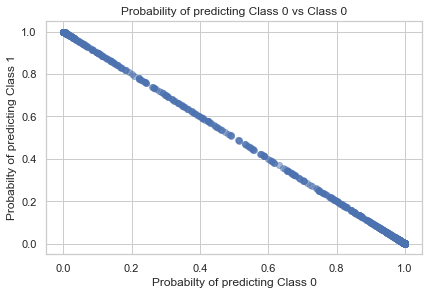

In [68]:
fig, ax = plt.subplots()
plt.scatter(svm_lin_probs[:,0], svm_lin_probs[:,1], alpha=0.5)

plt.title('Probability of predicting Class 0 vs Class 0')
ax.set_xlabel('Probabilty of predicting Class 0')
ax.set_ylabel('Probabilty of predicting Class 1')

plt.show()

In [69]:
count = 0
for val in svm_lin_probs[:,0]:
    if 0.8 > val > 0.2:
        count += 1
        print(val)

print(f"# of val around 0.5 = {count}")
print(f"% of val around 0.5 = {count/len(svm_lin_probs[:,1])}")

0.5313009079735511
0.2986362749623305
0.3761078508523502
0.4897592123632969
0.29902407992164654
0.3666816512606012
0.29948757702471085
0.39120794390235136
0.3968722232362767
0.7918497173883419
0.6764707145101211
0.26213940256437424
0.77795133959868
0.24142040254775574
0.5888738075960958
0.441934056596483
0.7148458918320933
0.30628662159838443
0.4105469758301091
0.26649702407312975
0.767137944132495
0.6174123877543661
0.5749667166903683
0.6762486225345712
0.30726207550258355
0.23948604427789177
0.7388656863352253
0.3219343935047197
0.4589465013569462
0.3034210941696149
0.5412469079314483
0.4434604624807761
0.48188031892757793
0.32715992262037735
0.6643972407298976
0.42256942363186906
0.7500083369178604
0.2436540889377728
0.3490087995217405
0.3660010618917253
0.7495895328685551
0.7023873613104943
0.7869541669101832
0.49151123788520196
0.7986715377357028
0.20153067390102125
0.644440050678691
0.6822388528869746
0.5838589651934732
0.7675415305689778
0.35656367968400954
0.5115043427774493
0.

In [70]:
count = 0
for val in svm_lin_probs[:,1]:
    if val >= 0.9:
        count += 1
        print(val)

print(f"# of val above 0.9 = {count}")
print(f"% of val above 0.9 = {count/len(svm_lin_probs[:,1])}")

0.9946945808752582
0.9999390581907789
1.0
0.9999612251988033
1.0
0.9779608946754065
0.9965353269348017
1.0
0.9999774345216136
0.9999999998192024
1.0
0.999884975358085
1.0
0.9999999999999929
1.0
1.0
0.9999999999791669
0.9976079858524912
0.992611445204292
1.0
0.9776359789950628
0.9997557988355487
0.9999999999950901
1.0
0.9999961893652541
0.9981059394906774
1.0
0.9999994479269635
0.9999999999240572
0.998998216243904
1.0
0.9921825441627146
0.9999999999644871
0.9999999787475462
0.9999999999986287
1.0
0.9828492252357773
0.9999999999998721
1.0
0.9967989638091757
0.9502023486008395
1.0
1.0
1.0
0.9999997500186196
0.9999806362055108
0.9999999983405132
1.0
1.0
0.9999999999997868
0.9916668356296278
0.9999999984554293
0.9676678435199536
0.9999999523424148
0.990038528558318
0.999999659566954
1.0
1.0
1.0
0.9999999999987921
0.9999988918680203
0.9999999999990976
1.0
1.0
1.0
0.9999999998983427
1.0
1.0
1.0
1.0
0.9998857009675408
0.9999999999999147
0.9526127349329861
0.9999999999999858
0.9993105074943016


1.0
1.0
1.0
1.0
0.9998696876724279
1.0
1.0
0.99999999998753
# of val above 0.9 = 849
% of val above 0.9 = 0.019003917179630667


### Classifier 4: Random Forest

In [138]:
from sklearn.ensemble import RandomForestClassifier

In [139]:
%%time
clf_rdf = RandomForestClassifier(n_jobs=-1,
                       random_state=42,
#                        verbose=2,
                                )

clf_rdf.fit(X_train,y_train)

Wall time: 6.54 s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [140]:
%%time
clf_rdf.score(X_test,y_test)

ValueError: X has 8 features, but DecisionTreeClassifier is expecting 4 features as input.

In [92]:
%%time
from sklearn.model_selection import cross_val_score

clf_rdf_cvs = cross_val_score(clf_rdf, X, y, 
                              cv=10, 
                              n_jobs=-1,)

print(f"GaussianNB 10-CV score: {clf_rdf_cvs}")
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(clf_rdf_cvs)}")

GaussianNB 10-CV score: [0.95903749 0.96994964 0.97140459 0.97241186 0.96961388 0.9697258
 0.97095691 0.9700056  0.96966984 0.9692764 ]
GaussianNB 10-fold Cross Val Avg: 0.9692052002036959
Wall time: 1min 32s


In [95]:
clf_rdf_predicted = clf_rdf.predict(X_test)
clf_rdf_precision = precision_score(y_test, clf_rdf_predicted)
clf_rdf_recall = recall_score(y_test, clf_rdf_predicted)
clf_rdf_f1 = f1_score(y_test, clf_rdf_predicted)

print(f'Precision Score: {clf_rdf_precision}')
print(f'Recall Score: {clf_rdf_recall}')
print(f'F1 Score: {clf_rdf_f1}')

Precision Score: 0.5036496350364964
Recall Score: 0.051646706586826345
F1 Score: 0.09368635437881873


In [52]:
rdf_probs = GNB.predict_proba(X_test)

In [53]:
print(f"min of left col = {min(rdf_probs[:,0])}, max of right col = {max(rdf_probs[:,1])}")
print(f"max of left col = {max(rdf_probs[:,0])}, min of right col = {min(rdf_probs[:,1])}")

min of left col = 0.0, max of right col = 1.0
max of left col = 0.999964201117343, min of right col = 3.579888265721081e-05


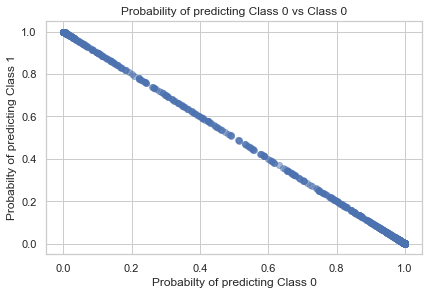

In [54]:
fig, ax = plt.subplots()
plt.scatter(rdf_probs[:,0], rdf_probs[:,1], alpha=0.5)

plt.title('Probability of predicting Class 0 vs Class 0')
ax.set_xlabel('Probabilty of predicting Class 0')
ax.set_ylabel('Probabilty of predicting Class 1')

plt.show()

In [57]:
count = 0
for val in rdf_probs[:,0]:
    if 0.8 > val > 0.2:
        count += 1
        print(val)

print(f"# of val around 0.5 = {count}")
print(f"% of val around 0.5 = {count/len(rdf_probs[:,1])}")

0.5313009079735511
0.2986362749623305
0.3761078508523502
0.4897592123632969
0.29902407992164654
0.3666816512606012
0.29948757702471085
0.39120794390235136
0.3968722232362767
0.7918497173883419
0.6764707145101211
0.26213940256437424
0.77795133959868
0.24142040254775574
0.5888738075960958
0.441934056596483
0.7148458918320933
0.30628662159838443
0.4105469758301091
0.26649702407312975
0.767137944132495
0.6174123877543661
0.5749667166903683
0.6762486225345712
0.30726207550258355
0.23948604427789177
0.7388656863352253
0.3219343935047197
0.4589465013569462
0.3034210941696149
0.5412469079314483
0.4434604624807761
0.48188031892757793
0.32715992262037735
0.6643972407298976
0.42256942363186906
0.7500083369178604
0.2436540889377728
0.3490087995217405
0.3660010618917253
0.7495895328685551
0.7023873613104943
0.7869541669101832
0.49151123788520196
0.7986715377357028
0.20153067390102125
0.644440050678691
0.6822388528869746
0.5838589651934732
0.7675415305689778
0.35656367968400954
0.5115043427774493
0.

In [55]:
count = 0
for val in rdf_probs[:,1]:
    if val >= 0.9:
        count += 1
        print(val)

print(f"# of val above 0.9 = {count}")
print(f"% of val above 0.9 = {count/len(rdf_probs[:,1])}")

0.9946945808752582
0.9999390581907789
1.0
0.9999612251988033
1.0
0.9779608946754065
0.9965353269348017
1.0
0.9999774345216136
0.9999999998192024
1.0
0.999884975358085
1.0
0.9999999999999929
1.0
1.0
0.9999999999791669
0.9976079858524912
0.992611445204292
1.0
0.9776359789950628
0.9997557988355487
0.9999999999950901
1.0
0.9999961893652541
0.9981059394906774
1.0
0.9999994479269635
0.9999999999240572
0.998998216243904
1.0
0.9921825441627146
0.9999999999644871
0.9999999787475462
0.9999999999986287
1.0
0.9828492252357773
0.9999999999998721
1.0
0.9967989638091757
0.9502023486008395
1.0
1.0
1.0
0.9999997500186196
0.9999806362055108
0.9999999983405132
1.0
1.0
0.9999999999997868
0.9916668356296278
0.9999999984554293
0.9676678435199536
0.9999999523424148
0.990038528558318
0.999999659566954
1.0
1.0
1.0
0.9999999999987921
0.9999988918680203
0.9999999999990976
1.0
1.0
1.0
0.9999999998983427
1.0
1.0
1.0
1.0
0.9998857009675408
0.9999999999999147
0.9526127349329861
0.9999999999999858
0.9993105074943016


## Reappending the prediction probabilites after Gaussian NB back on X_test, to observe some behavior

1. Add predicts back on to new dataframe with X_test
2. use clf to parse for feature importance

In [ ]:
 GNB.predict(X_test)

In [60]:
X_test_probs = X_test
X_test_probs['prob_0'] = GNB_probs[:,0]
X_test_probs['prob_1'] = GNB_probs[:,1]
X_test_probs['predict_class'] = GNB_predicted
X_test_probs['label'] = y_test
X_test_probs

,views,likes,dislikes,comment_count,prob_0,prob_1,predict_class,label
117989,2592,125,2,3,0.999961,0.000039,0,0
101258,30968,1900,32,219,0.999962,0.000038,0,0
44861,39277,720,72,312,0.999962,0.000038,0,0
5811,77884,814,119,617,0.999963,0.000037,0,0
63847,136815,362,201,375,0.999963,0.000037,0,0
...,...,...,...,...,...,...,...,...
131037,8259,569,4,86,0.999961,0.000039,0,0
112353,287445,1475,133,522,0.999962,0.000038,0,0
75019,78071,1191,42,33,0.999963,0.000037,0,0
93855,88752,1043,146,118,0.999963,0.000037,0,0


In [62]:
GNB.feature_log_prob_

AttributeError: 'GaussianNB' object has no attribute 'feature_log_prob_'

In [ ]:
X_test_probs

In [143]:
# to first affirm that prob_0 and prob_1 were truly labeled as what they were supposed to be

count = 0
for i, row in X_test_probs.iterrows():
    count += 1
    if count > 5:
        break
    print(f'i:{i}, V:{row.views}, L:{row.likes}, D:{row.dislikes}, C:{row.comment_count}')
    print(f'i:{i}, Prob_0:{row.prob_0}, Prob_1:{row.prob_1}, Label:{row.label}\n')

i:117989, V:2592.0, L:125.0, D:2.0, C:3.0
i:117989, Prob_0:0.9999606178791351, Prob_1:3.938212086728837e-05, Label:0.0

i:101258, V:30968.0, L:1900.0, D:32.0, C:219.0
i:101258, Prob_0:0.9999622281901729, Prob_1:3.7771809827312226e-05, Label:0.0

i:44861, V:39277.0, L:720.0, D:72.0, C:312.0
i:44861, Prob_0:0.9999621804001358, Prob_1:3.781959986346604e-05, Label:0.0

i:5811, V:77884.0, L:814.0, D:119.0, C:617.0
i:5811, Prob_0:0.9999630191510568, Prob_1:3.6980848944498326e-05, Label:0.0

i:63847, V:136815.0, L:362.0, D:201.0, C:375.0
i:63847, Prob_0:0.9999632510195968, Prob_1:3.674898040076434e-05, Label:0.0



In [141]:
count = 0
for i, row in X_caltest_probs.iterrows():
    if 0.65 > row.prob_0 > 0.45:
        count += 1
        print(f'i:{i}, V:{row.views}, L:{row.likes}, D:{row.dislikes}, C:{row.comment_count}')
        print(f'i:{i}, Prob_0:{row.prob_0}, Prob_1:{row.prob_1}, Label:{row.label}\n')
        
print(f'\nCount = {count}')

i:9789, V:2084873.0, L:19453.0, D:2282.0, C:1644.0
i:9789, Prob_0:0.5313009079735511, Prob_1:0.46869909202645066, Label:0.0

i:8262, V:2088123.0, L:10710.0, D:2855.0, C:2811.0
i:8262, Prob_0:0.4897592123632969, Prob_1:0.5102407876367043, Label:0.0

i:77976, V:921137.0, L:85063.0, D:770.0, C:6498.0
i:77976, Prob_0:0.5888738075960958, Prob_1:0.41112619240390497, Label:0.0

i:31373, V:2021614.0, L:31146.0, D:1311.0, C:714.0
i:31373, Prob_0:0.6174123877543661, Prob_1:0.3825876122456337, Label:0.0

i:62914, V:2069066.0, L:6406.0, D:2858.0, C:600.0
i:62914, Prob_0:0.5749667166903683, Prob_1:0.4250332833096282, Label:0.0

i:23078, V:1381081.0, L:63187.0, D:3192.0, C:8976.0
i:23078, Prob_0:0.4589465013569462, Prob_1:0.5410534986430561, Label:0.0

i:123837, V:319508.0, L:48457.0, D:8515.0, C:8050.0
i:123837, Prob_0:0.5412469079314483, Prob_1:0.45875309206855397, Label:0.0

i:178219, V:1396553.0, L:70255.0, D:645.0, C:7952.0
i:178219, Prob_0:0.48188031892757793, Prob_1:0.51811968107242, Label:1.

### Other observations

In [19]:
len(X_test)

44675

In [94]:
np.array(X_test[19:20])

array([[7996,  301,   17,   21]], dtype=int64)

In [90]:
y_test[19:20]

126472    0
Name: trend_over_5_days, dtype: int64

In [89]:
GNB.predict_proba(X_test[:-1])

array([[9.99960896e-01, 3.91040573e-05]])

In [74]:
GNB.predict(X_test[5::-1])

array([0, 0, 0, 0, 0, 0], dtype=int64)

In [96]:
# custom 
print(GNB.predict(np.array([[17158579, 787425, 43420, 125882]])))
print(GNB.predict_proba(np.array([[17158579, 787425, 43420, 125882]])))

[1]
[[0. 1.]]


In [99]:
# custom 
arr2 = [4567, 787, 430, 125]
print(GNB.predict(np.array([arr2])))
print(GNB.predict_proba(np.array([arr2])))

[0]
[[9.99961354e-01 3.86463172e-05]]


### Using only views, comments, and likes to graph 3D

In [21]:
X3 = X.drop(['dislikes'],axis=1)
X3

,views,likes,comment_count
0,17158579,787425,125882
1,1014651,127794,13030
2,3191434,146035,8181
3,2095828,132239,17518
4,33523622,1634130,85067
...,...,...,...
178694,279728,19691,579
178695,1549110,21905,1318
178696,2183462,79677,3464
178697,607422,26166,3517


In [22]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.25, random_state=42)

In [23]:
X3_train

,views,likes,comment_count
113617,126706,6061,4418
65534,14658,122,9
126111,9568,141,10
8740,32051,3006,665
57496,11716,2018,130
...,...,...,...
119879,7996,38,14
103694,78227,1082,356
131932,98261,501,23
146867,16583,177,33


In [24]:
y3_train

113617    0
65534     0
126111    0
8740      0
57496     0
         ..
119879    0
103694    0
131932    0
146867    0
121958    0
Name: trend_over_5_days, Length: 134024, dtype: int64

### Gaussian Naive Bayes on views, comments, likes, only

In [27]:
GNB_3 = GaussianNB()
GNB_3.fit(X3_train, y3_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [28]:
GNB_3.score(X3_test, y3_test)

0.9596642417459429

In [29]:
from sklearn.model_selection import cross_val_score

GNB_3_cvs = cross_val_score(GNB_3, X, y, 
                          cv=10, 
                          n_jobs=-1,)

print(GNB_3_cvs)
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(GNB_3_cvs)}")

[0.92126469 0.95422496 0.96552882 0.97437045 0.9616676  0.96614438
 0.96205932 0.96149972 0.95148293 0.95327103]
GaussianNB 10-fold Cross Val Avg: 0.9571513893174485


### Bernoulli Naive Bayes on 4 stats, then the 3 stats

In [30]:
from sklearn.naive_bayes import BernoulliNB

BNB = BernoulliNB()
BNB.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [31]:
BNB.score(X_test, y_test)

0.9700951315053161

In [32]:
BNB_cvs = cross_val_score(BNB, X, y, 
                          cv=10, 
                          n_jobs=-1,)

print(f"GaussianNB 10-CV score: {BNB_cvs}")
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(BNB_cvs)}")

GaussianNB 10-CV score: [0.97011752 0.97011752 0.97011752 0.97011752 0.97011752 0.97011752
 0.97017348 0.97017348 0.97017348 0.97017181]
GaussianNB 10-fold Cross Val Avg: 0.9701397323548177


In [33]:
from sklearn.naive_bayes import BernoulliNB

BNB = BernoulliNB()
BNB.fit(X3_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [34]:
BNB.score(X3_test, y_test)

0.9700951315053161

In [35]:
BNB_cvs = cross_val_score(BNB, X, y, 
                          cv=10, 
                          n_jobs=-1,)

print(f"GaussianNB 10-CV score: {BNB_cvs}")
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(BNB_cvs)}")

GaussianNB 10-CV score: [0.97011752 0.97011752 0.97011752 0.97011752 0.97011752 0.97011752
 0.97017348 0.97017348 0.97017348 0.97017181]
GaussianNB 10-fold Cross Val Avg: 0.9701397323548177


### Random Forest Classifier on 4 stats, looking at feature importance

In [37]:
%%time 
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [38]:
%%time
rf_clf.score(X_test,y_test)

Wall time: 793 ms


0.9700279798545047

## Taking a look at feature importance from Random Forest

In [43]:
# quick investigation into the correlation of features to the label
df_nostr.corr()["trend_over_5_days"].sort_values(ascending=False)

trend_over_5_days    1.000000
likes                0.214585
views                0.208136
comment_count        0.136254
dislikes             0.074938
Name: trend_over_5_days, dtype: float64

In [44]:
rf_clf.feature_importances_

array([0.29690223, 0.27675522, 0.20153348, 0.22480906])

<BarContainer object of 4 artists>

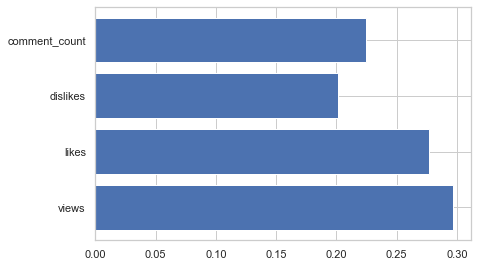

In [46]:
plt.barh(X.columns, rf_clf.feature_importances_)

In [48]:
%%time
import shap

explainer = shap.TreeExplainer(rf_clf)

Wall time: 125 ms


In [50]:
%%time
shap_values = explainer.shap_values(X_test)

Wall time: 53min 38s


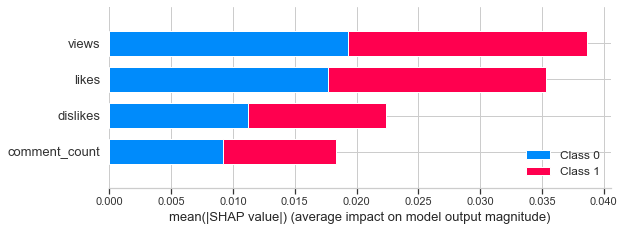

In [52]:
shap.summary_plot(shape_values, X_test, plot_type="bar")

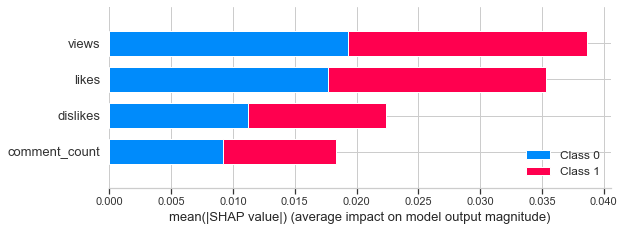

In [55]:
shap.summary_plot(shape_values, X_train)

In [56]:
# X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
# y = np.array([1, 1, 2, 2])
# from sklearn.svm import SVC
# clf = SVC(probability=True)
# clf.fit(X, y) 
# print(clf.predict([[-0.8, -1]]))
# print(clf.predict_proba([[-0.8, -1]]))

[1]
[[0.8656444 0.1343556]]


### Heat Map remade with Spearman's rank correlation 

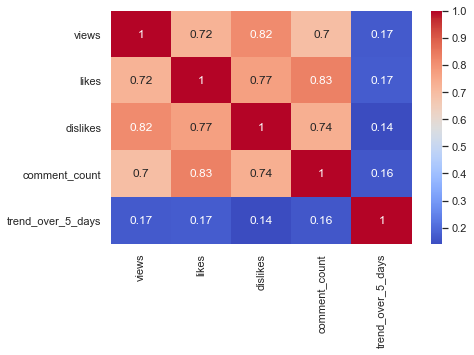

In [107]:
import seaborn as sns

sns.heatmap(df_nostr.corr(method='spearman'),annot=True,cmap='coolwarm')

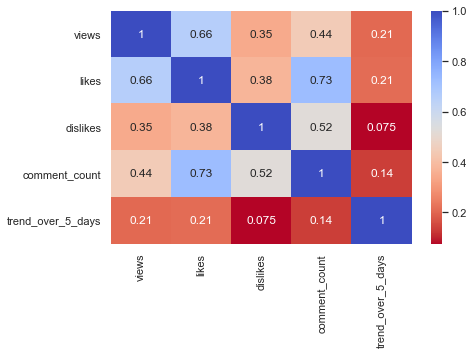

In [102]:
sns.heatmap(df_nostr.corr(method='pearson'),annot=True,cmap='coolwarm_r')

In [104]:
df_nostr.corr(method='pearson')['trend_over_5_days']

views                0.208136
likes                0.214585
dislikes             0.074938
comment_count        0.136254
trend_over_5_days    1.000000
Name: trend_over_5_days, dtype: float64